In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import keras

from dataclasses import dataclass

In [ ]:
@dataclass(frozen=True)
class DataConfig():
  IMG_HEIGHT:    int = 28
  IMG_WIDTH:    int = 28
  NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainConfig:
  BATCH_SIZE:    int = 32
  EPOCHS:        int = 100
  LEARNING_RATE: int = 0.001

In [ ]:
(train_set, val_set, test_set), info = tfds.load('malaria', split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
                                                 as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete4R7AUD/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info.citation)

@article{rajaraman2018pre,
  title={Pre-trained convolutional neural networks as feature extractors toward
  improved malaria parasite detection in thin blood smear images},
  author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
  and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger,
  Stefan and Thoma, George R},
  journal={PeerJ},
  volume={6},
  pages={e4568},
  year={2018},
  publisher={PeerJ Inc.}
}


In [ ]:
print(f"Classes:{info.features['label'].num_classes}\nClass names: {info.features['label'].names}")

Classes:2
Class names: ['parasitized', 'uninfected']


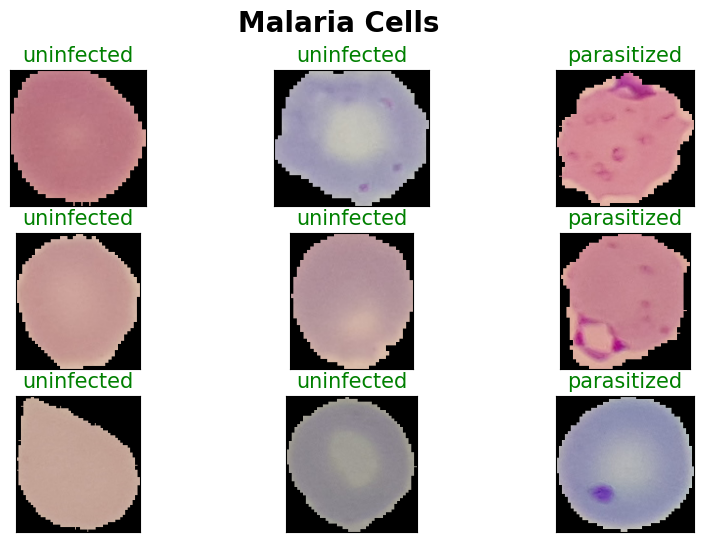

In [ ]:
fig = plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_set.take(9)):
  ax = fig.add_subplot(3, 3, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(image)
  ax.set_title('{}'.format(info.features['label'].int2str(label)), size=15, color='green')
fig.suptitle("Malaria Cells", weight='bold', size=20)
plt.axis(True)
plt.show()

In [ ]:
def normalize_images(image, label):
  img_resize = tf.image.resize(image, (DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH))
  img_scale = tf.cast(img_resize, tf.float32) / 255.0

  return img_scale, label

def preprocess_inputs(dataset: tf.data.Dataset):
  ds = dataset.cache()
  ds = ds.map(normalize_images)
  ds = ds.batch(TrainConfig.BATCH_SIZE)
  ds = ds.shuffle(buffer_size=len(dataset))
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return ds

val = preprocess_inputs(val_set)

In [ ]:
image_batch, label_batch = next(iter(val))
print(image_batch[0].shape, label_batch)

(28, 28, 3) tf.Tensor([1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0], shape=(32,), dtype=int64)


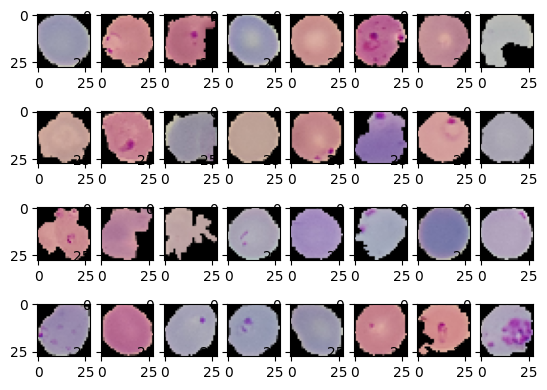

In [ ]:
for i, (image, label) in enumerate(zip(image_batch, label_batch)):
  plt.subplot(4, 8, i+1)
  plt.imshow(image, cmap='gray_r')
plt.show()

### Split the dataset.

In [ ]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 28, 28, 128)       512       
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 100865 (394.00 KB)
Trainable params: 100865 (394.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
train = preprocess_inputs(train_set)
history = base_model.fit(train, epochs=21,
                         validation_data=val)

Epoch 1/21
603/603 [==============================] - 26s 22ms/step - loss: 0.6228 - accuracy: 0.6593 - val_loss: 0.5899 - val_accuracy: 0.6801
Epoch 2/21
603/603 [==============================] - 14s 22ms/step - loss: 0.5765 - accuracy: 0.7083 - val_loss: 0.5867 - val_accuracy: 0.6818
Epoch 3/21
603/603 [==============================] - 15s 22ms/step - loss: 0.5486 - accuracy: 0.7314 - val_loss: 0.5392 - val_accuracy: 0.7278
Epoch 4/21
603/603 [==============================] - 15s 23ms/step - loss: 0.5216 - accuracy: 0.7568 - val_loss: 0.5054 - val_accuracy: 0.7660
Epoch 5/21
603/603 [==============================] - 15s 23ms/step - loss: 0.4924 - accuracy: 0.7846 - val_loss: 0.4782 - val_accuracy: 0.8014
Epoch 6/21
 32/603 [>.............................] - ETA: 28s - loss: 0.4954 - accuracy: 0.7734

In [ ]:
def plot_results(metrics, metric_name=None, title=None, ylabel=None, ylim=None, color=None):
  fig, ax = plt.subplots(figsize=(15, 4))

  if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
    metrics = [metrics]
    metric_name = [metric_name]

  for idx, metric in enumerate(metrics):
    ax.plot(metric, color=color[idx])

  plt.xlabel("Epochs")
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim([0, 100])
  plt.title(title)

  # Tailor x-axis tick marks.
  ax.xaxis.set_major_locator(plt.MultipleLocator(5))
  ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
  plt.grid(True)
  plt.legend(metric_name)
  plt.show()
  plt.close()

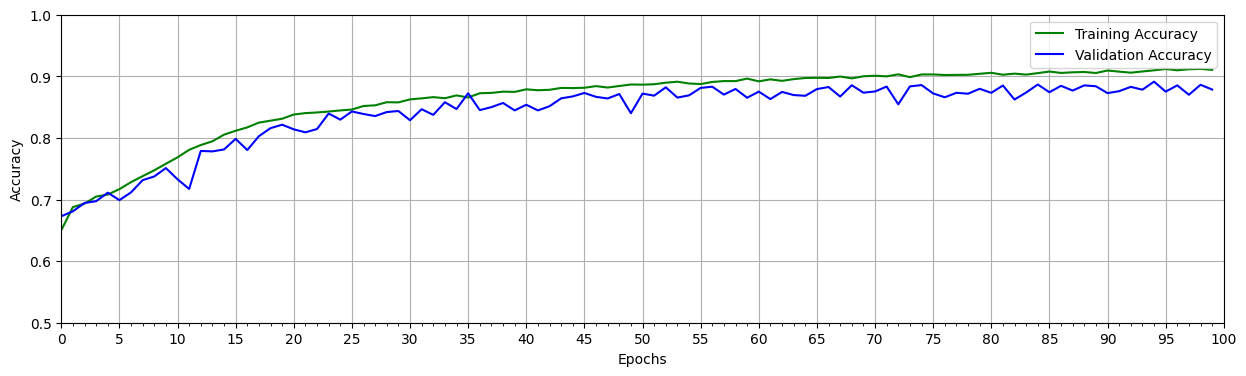

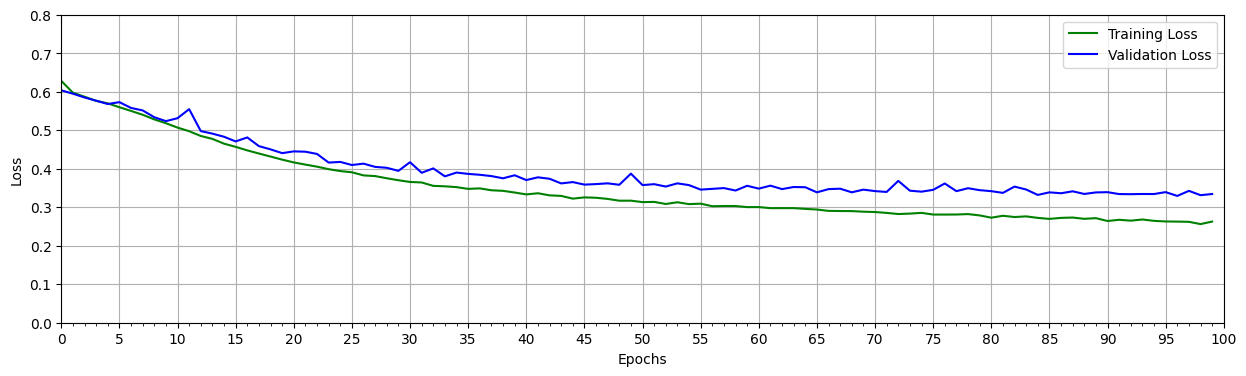

In [ ]:
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plot_results([train_acc, val_acc],
             metric_name=['Training Accuracy', 'Validation Accuracy'],
             ylabel="Accuracy", ylim=[0.5, 1.0],
             color=['g', 'b'])

plot_results([train_loss, val_loss],
             metric_name=['Training Loss', 'Validation Loss'],
             ylabel="Loss", ylim=[0.0, 0.8],
             color=['g', 'b'])

### Predictions.

In [ ]:
test_ds = preprocess_inputs(test_set)

class_names = info.features['label'].names

true_labels = []
predicted_labels = []

for images, labels in test_ds.take(2):
    # Store ground truth labels
    true_labels.extend(labels.numpy())

    # Predict classes for the batch of images
    predictions = base_model.predict(images)

    # Store predicted labels
    predicted_labels.extend(predictions)

# Convert predicted probabilities to class labels
predicted_labels = [1 if prediction >= 0.5 else 0 for prediction in predicted_labels]

# Print ground truth and predicted classes for the first few images
for i in range(2):
    true_class = class_names[true_labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    print(f"Ground truth for test image {i + 1}: {true_class}")
    print(f"Predicted class for test image {i + 1}: {predicted_class}")


1/1 [==============================] - 0s 22ms/step
Ground truth for test image 1: parasitized
Predicted class for test image 1: parasitized
Ground truth for test image 2: parasitized
Predicted class for test image 2: parasitized
